# Modeling Wpdx + Environmental Data using XGBoost

In [111]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import necessary libraries

In [112]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline



### Read and explore the data

In [113]:
df = pd.read_csv(r"C:\Users\ADMIN\Documents\MoringaSchool\Phase5\CleanWatAI\notebooks\data\processed\environmental.csv")
df.head()




,row_id,source,lat_deg,lon_deg,report_date,status_id,water_source_clean,water_source_category,water_tech_clean,_water_tech_category,...,chirps_7_precipitation,chirps_30_precipitation,chirps_90_precipitation,ndvi_7_NDVI,ndvi_30_NDVI,ndvi_90_NDVI,lst_7_LST_Day_1km,lst_30_LST_Day_1km,lst_90_LST_Day_1km,pop_population
0,215873,Evidence Action,0.174668,34.554572,2023-02-11T00:00:00.000,Yes,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,...,4.914062,5.804299,11.215961,0.7685,0.77920,0.765850,23.35,23.620,24.402727,10.462028
1,215240,Evidence Action,0.220830,34.565483,2023-11-15T00:00:00.000,Yes,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,...,3.862696,5.864281,11.359583,0.7642,0.77615,0.745817,23.63,23.370,24.260909,6.315442
2,194605,Evidence Action,0.044235,34.339775,2023-11-15T00:00:00.000,Yes,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,...,2.113567,2.798805,7.549499,0.7348,0.73455,0.716650,24.89,24.350,24.922000,5.745561
3,219017,Evidence Action,-0.449933,34.794163,2023-11-17T00:00:00.000,Yes,Borehole/Tubewell,Well,NaN,NaN,...,2.045830,2.790391,7.499787,0.7235,0.73420,0.730017,24.41,24.310,24.433636,3.103306
4,587740,USAID/KEA KIWASH,0.497160,34.831463,2021-02-05T00:00:00.000,No,Undefined Well,Well,Public Tapstand,Public Tapstand,...,4.075452,5.655031,9.077165,0.7256,0.74335,0.711867,23.79,23.435,24.326000,7.758868


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21368 entries, 0 to 21367
Data columns (total 85 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   row_id                      21368 non-null  int64  
 1   source                      21368 non-null  object 
 2   lat_deg                     21368 non-null  float64
 3   lon_deg                     21368 non-null  float64
 4   report_date                 21368 non-null  object 
 5   status_id                   21368 non-null  object 
 6   water_source_clean          21342 non-null  object 
 7   water_source_category       21342 non-null  object 
 8   water_tech_clean            15937 non-null  object 
 9   _water_tech_category        15787 non-null  object 
 10  facility_type               21368 non-null  object 
 11  clean_country_name          21368 non-null  object 
 12  clean_country_id            21368 non-null  object 
 13  clean_adm1                  213

## Data Cleaning and Preprocessing

### Null values

In [115]:
# check null values
null_columns = df.columns[df.isnull().any()]
if not null_columns.empty:
    print("Columns with null values:")
    print(df[null_columns].isnull().sum())
else:
    print("There are no null values in the DataFrame.")   
    

Columns with null values:
water_source_clean               26
water_source_category            26
water_tech_clean               5431
_water_tech_category           5581
clean_adm4                    21368
install_year                  14965
installer                     16343
rehab_year                    21368
rehabilitator                 21368
management_clean              14970
pay_clean                     20563
fecal_coliform_presence       21368
fecal_coliform_value          21368
subjective_quality_clean      14949
activity_id                     504
scheme_id                     21368
notes                         20606
orig_lnk                      20557
photo_lnk                     14949
country_id                       14
distance_to_city                 10
local_population                202
served_population               202
rehab_priority                18837
_pop_who_would_gain_access    18899
crucialness                     222
pressure                        438
us

### Deal with missing values

- so many missing values 
- lets drop the columns where (entirely missing, metadata, irrelevant for modelling)

In [116]:
# Drop columns with 0 usable data
drop_cols = [
    'clean_adm4', 'rehab_year', 'rehabilitator',
    'fecal_coliform_presence', 'fecal_coliform_value',
    'scheme_id', 'pay_clean', 'pay', 'notes', 'orig_lnk',
    'is_duplicate', 'photo_lnk', 'installer', 'converted',
    'subjective_quality', 'subjective_quality_clean'
]

# Drop metadata or duplicative fields
meta_cols = [
    'report_date', 'row_id', 'source', 'activity_id', 'pt_id', 'data_lnk',
    'country_id', 'status_id', 'new_georeferenced_column_',
    'lat_lon_deg', 'created_timestamp', 'updated', 'dataset_title',
    'water_point_history', 'orig_lnk', 'photo_lnk', 'public_data_source'
]
df.drop(columns=drop_cols + meta_cols, inplace=True, errors='ignore')

df.head()

,lat_deg,lon_deg,water_source_clean,water_source_category,water_tech_clean,_water_tech_category,facility_type,clean_country_name,clean_country_id,clean_adm1,...,chirps_7_precipitation,chirps_30_precipitation,chirps_90_precipitation,ndvi_7_NDVI,ndvi_30_NDVI,ndvi_90_NDVI,lst_7_LST_Day_1km,lst_30_LST_Day_1km,lst_90_LST_Day_1km,pop_population
0,0.174668,34.554572,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Kakamega,...,4.914062,5.804299,11.215961,0.7685,0.77920,0.765850,23.35,23.620,24.402727,10.462028
1,0.220830,34.565483,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Kakamega,...,3.862696,5.864281,11.359583,0.7642,0.77615,0.745817,23.63,23.370,24.260909,6.315442
2,0.044235,34.339775,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Siaya,...,2.113567,2.798805,7.549499,0.7348,0.73455,0.716650,24.89,24.350,24.922000,5.745561
3,-0.449933,34.794163,Borehole/Tubewell,Well,NaN,NaN,Improved,Kenya,KEN,Homa Bay,...,2.045830,2.790391,7.499787,0.7235,0.73420,0.730017,24.41,24.310,24.433636,3.103306
4,0.497160,34.831463,Undefined Well,Well,Public Tapstand,Public Tapstand,Improved,Kenya,KEN,Kakamega,...,4.075452,5.655031,9.077165,0.7256,0.74335,0.711867,23.79,23.435,24.326000,7.758868


In [117]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21368 entries, 0 to 21367
Data columns (total 54 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   lat_deg                     21368 non-null  float64
 1   lon_deg                     21368 non-null  float64
 2   water_source_clean          21342 non-null  object 
 3   water_source_category       21342 non-null  object 
 4   water_tech_clean            15937 non-null  object 
 5   _water_tech_category        15787 non-null  object 
 6   facility_type               21368 non-null  object 
 7   clean_country_name          21368 non-null  object 
 8   clean_country_id            21368 non-null  object 
 9   clean_adm1                  21368 non-null  object 
 10  clean_adm2                  21368 non-null  object 
 11  clean_adm3                  21368 non-null  object 
 12  install_year                6403 non-null   float64
 13  management_clean            639

In [118]:
# Drop high-missing-value columns (> 30% missing)
high_missing_cols = df.isnull().mean()
drop_cols = high_missing_cols[high_missing_cols > 0.3].index

df = df.drop(columns=drop_cols)

# Drop rows missing critical categorical columns
essential_cat_cols = [
    'water_source_clean',
    'water_source_category',
    'water_tech_clean',
    '_water_tech_category',
    'facility_type'
]

df = df.dropna(subset=essential_cat_cols)

# Fill missing values in numeric columns with the median
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill missing values in categorical columns with the mode
cat_cols = df.select_dtypes(include='object').columns

for col in cat_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])

# Final check
print("Remaining missing values per column:")
print(df.isnull().sum().sort_values(ascending=False))


Remaining missing values per column:
lat_deg                    0
latitude                   0
location_id                0
is_urban                   0
cluster_size               0
country_name               0
water_source               0
adm1                       0
adm2                       0
adm3                       0
count                      0
longitude                  0
staleness_score            0
chirps_7_precipitation     0
chirps_30_precipitation    0
chirps_90_precipitation    0
ndvi_7_NDVI                0
ndvi_30_NDVI               0
ndvi_90_NDVI               0
lst_7_LST_Day_1km          0
lst_30_LST_Day_1km         0
lst_90_LST_Day_1km         0
is_latest                  0
days_since_report          0
lon_deg                    0
clean_adm3                 0
water_source_clean         0
water_source_category      0
water_tech_clean           0
_water_tech_category       0
facility_type              0
clean_country_name         0
clean_country_id           0
clean_

In [119]:
df_cleaned = df.copy()

df_cleaned.head()

,lat_deg,lon_deg,water_source_clean,water_source_category,water_tech_clean,_water_tech_category,facility_type,clean_country_name,clean_country_id,clean_adm1,...,chirps_7_precipitation,chirps_30_precipitation,chirps_90_precipitation,ndvi_7_NDVI,ndvi_30_NDVI,ndvi_90_NDVI,lst_7_LST_Day_1km,lst_30_LST_Day_1km,lst_90_LST_Day_1km,pop_population
0,0.174668,34.554572,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Kakamega,...,4.914062,5.804299,11.215961,0.7685,0.77920,0.765850,23.35,23.620,24.402727,10.462028
1,0.220830,34.565483,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Kakamega,...,3.862696,5.864281,11.359583,0.7642,0.77615,0.745817,23.63,23.370,24.260909,6.315442
2,0.044235,34.339775,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Siaya,...,2.113567,2.798805,7.549499,0.7348,0.73455,0.716650,24.89,24.350,24.922000,5.745561
4,0.497160,34.831463,Undefined Well,Well,Public Tapstand,Public Tapstand,Improved,Kenya,KEN,Kakamega,...,4.075452,5.655031,9.077165,0.7256,0.74335,0.711867,23.79,23.435,24.326000,7.758868
5,0.134735,34.687273,Protected Well,Well,Public Tapstand,Public Tapstand,Improved,Kenya,KEN,Kakamega,...,5.567590,5.462062,10.701967,0.7659,0.77880,0.763500,23.73,23.325,24.079091,9.620794


In [120]:
df_cleaned.shape

(15761, 47)

In [121]:
print(df_cleaned.dtypes)


lat_deg                    float64
lon_deg                    float64
water_source_clean          object
water_source_category       object
water_tech_clean            object
_water_tech_category        object
facility_type               object
clean_country_name          object
clean_country_id            object
clean_adm1                  object
clean_adm2                  object
clean_adm3                  object
status_clean                object
distance_to_primary        float64
distance_to_secondary      float64
distance_to_tertiary       float64
distance_to_city           float64
distance_to_town           float64
local_population           float64
served_population          float64
crucialness                float64
pressure                   float64
usage_cap                  float64
days_since_report            int64
staleness_score            float64
is_latest                     bool
location_id                  int64
is_urban                      bool
cluster_size        

In [122]:
# Categorical columns
for col in df_cleaned.columns:
    if df_cleaned[col].dtype == 'object':
        print(f"\nColumn: {col}")
        print(df_cleaned[col].unique())



Column: water_source_clean
['Protected Well' 'Undefined Well' 'Borehole/Tubewell' 'Piped Water'
 'Sand or Sub-surface Dam' 'Unprotected Well' 'Rainwater Harvesting'
 'Protected Spring' 'Delivered Water']

Column: water_source_category
['Well' 'Piped Water' 'Sand or Sub-surface Dam' 'Rainwater Harvesting'
 'Spring' 'Delivered Water']

Column: water_tech_clean
['Motorized Pump - Electric' 'Public Tapstand' 'Motorized Pump'
 'Hand Pump - Afridev' 'Hand Pump' 'Hand Pump - India Mark'
 'Hand Pump - Nira' 'Hand Pump - Blue' 'Hand Pump - Tara'
 'Rope and Bucket' 'Motorized Pump - Diesel' 'Hand Pump - Rope'
 'Hand Pump - SWN 80']

Column: _water_tech_category
['Motorized Pump' 'Public Tapstand' 'Hand Pump' 'Rope and Bucket']

Column: facility_type
['Improved' 'Improved - Other']

Column: clean_country_name
['Kenya']

Column: clean_country_id
['KEN']

Column: clean_adm1
['Kakamega' 'Siaya' 'Migori' 'Makueni' 'Busia' 'Kiambu' 'Embu' 'Kisumu'
 'Nyamira' 'Vihiga' 'Samburu' 'Homa Bay' 'Bungoma' 'K

### Duplicates

In [123]:
df_cleaned[df_cleaned.duplicated(subset=['latitude', 'longitude'], keep=False)].sort_values(by=['latitude', 'longitude'])


,lat_deg,lon_deg,water_source_clean,water_source_category,water_tech_clean,_water_tech_category,facility_type,clean_country_name,clean_country_id,clean_adm1,...,chirps_7_precipitation,chirps_30_precipitation,chirps_90_precipitation,ndvi_7_NDVI,ndvi_30_NDVI,ndvi_90_NDVI,lst_7_LST_Day_1km,lst_30_LST_Day_1km,lst_90_LST_Day_1km,pop_population
6425,0.027583,34.792957,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Vihiga,...,3.394601,4.261939,10.177632,0.7500,0.76610,0.772883,23.73,22.970,23.128182,7.322334
6426,0.027583,34.792957,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Vihiga,...,3.394601,4.261939,10.177632,0.7500,0.76610,0.772883,23.73,22.970,23.128182,7.322334
6427,0.027583,34.792957,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Vihiga,...,3.394601,4.261939,10.177632,0.7500,0.76610,0.772883,23.73,22.970,23.128182,7.322334
6428,0.027583,34.792957,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Vihiga,...,3.394601,4.261939,10.177632,0.7500,0.76610,0.772883,23.73,22.970,23.128182,7.322334
6429,0.027583,34.792957,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Vihiga,...,3.394601,4.261939,10.177632,0.7500,0.76610,0.772883,23.73,22.970,23.128182,7.322334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14698,0.506455,34.539471,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Bungoma,...,5.050976,5.135373,8.142502,0.7728,0.78145,0.759900,24.19,24.065,23.824000,5.037134
14699,0.506455,34.539471,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Bungoma,...,5.050976,5.135373,8.142502,0.7728,0.78145,0.759900,24.19,24.065,23.824000,5.037134
14700,0.506455,34.539471,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Bungoma,...,5.050976,5.135373,8.142502,0.7728,0.78145,0.759900,24.19,24.065,23.824000,5.037134
14701,0.506455,34.539471,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Bungoma,...,5.050976,5.135373,8.142502,0.7728,0.78145,0.759900,24.19,24.065,23.824000,5.037134


- the duplicate entries for identical latitude and longitude are completely identical across all relevant features

`We will drop because`:

- All numeric and categorical values match exactly.

- No temporal metadata (e.g., timestamp or year) is included.

- Repetition is likely the result of data duplication rather than meaningful sampling.


In [124]:
# Check for duplicates based on latitude and longitude
duplicates_geo = df_cleaned.duplicated(subset=['latitude', 'longitude'])

# Count duplicates
print("Duplicate locations:", duplicates_geo.sum())

# View duplicate rows
df_cleaned[duplicates_geo]


Duplicate locations: 12282


,lat_deg,lon_deg,water_source_clean,water_source_category,water_tech_clean,_water_tech_category,facility_type,clean_country_name,clean_country_id,clean_adm1,...,chirps_7_precipitation,chirps_30_precipitation,chirps_90_precipitation,ndvi_7_NDVI,ndvi_30_NDVI,ndvi_90_NDVI,lst_7_LST_Day_1km,lst_30_LST_Day_1km,lst_90_LST_Day_1km,pop_population
5091,0.506455,34.539471,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Bungoma,...,5.050976,5.135373,8.142502,0.7728,0.78145,0.7599,24.19,24.065,23.824000,5.037134
5092,0.506455,34.539471,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Bungoma,...,5.050976,5.135373,8.142502,0.7728,0.78145,0.7599,24.19,24.065,23.824000,5.037134
5093,0.506455,34.539471,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Bungoma,...,5.050976,5.135373,8.142502,0.7728,0.78145,0.7599,24.19,24.065,23.824000,5.037134
5094,0.506455,34.539471,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Bungoma,...,5.050976,5.135373,8.142502,0.7728,0.78145,0.7599,24.19,24.065,23.824000,5.037134
5095,0.506455,34.539471,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Bungoma,...,5.050976,5.135373,8.142502,0.7728,0.78145,0.7599,24.19,24.065,23.824000,5.037134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20951,0.169940,34.724442,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Kakamega,...,6.867427,6.798100,13.159847,0.7592,0.76785,0.7380,23.49,22.990,23.071818,6.440071
20952,0.169940,34.724442,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Kakamega,...,6.867427,6.798100,13.159847,0.7592,0.76785,0.7380,23.49,22.990,23.071818,6.440071
20953,0.169940,34.724442,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Kakamega,...,6.867427,6.798100,13.159847,0.7592,0.76785,0.7380,23.49,22.990,23.071818,6.440071
20954,0.169940,34.724442,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Kakamega,...,6.867427,6.798100,13.159847,0.7592,0.76785,0.7380,23.49,22.990,23.071818,6.440071


In [125]:
df_cleaned = df_cleaned.drop_duplicates(subset=['latitude', 'longitude'])


In [126]:
unique_points = df_cleaned[['latitude', 'longitude']].drop_duplicates()
print(f"Unique water point locations: {len(unique_points)}")


Unique water point locations: 3479


In [127]:
df_cleaned

,lat_deg,lon_deg,water_source_clean,water_source_category,water_tech_clean,_water_tech_category,facility_type,clean_country_name,clean_country_id,clean_adm1,...,chirps_7_precipitation,chirps_30_precipitation,chirps_90_precipitation,ndvi_7_NDVI,ndvi_30_NDVI,ndvi_90_NDVI,lst_7_LST_Day_1km,lst_30_LST_Day_1km,lst_90_LST_Day_1km,pop_population
0,0.174668,34.554572,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Kakamega,...,4.914062,5.804299,11.215961,0.7685,0.77920,0.765850,23.35,23.620,24.402727,10.462028
1,0.220830,34.565483,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Kakamega,...,3.862696,5.864281,11.359583,0.7642,0.77615,0.745817,23.63,23.370,24.260909,6.315442
2,0.044235,34.339775,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Siaya,...,2.113567,2.798805,7.549499,0.7348,0.73455,0.716650,24.89,24.350,24.922000,5.745561
4,0.497160,34.831463,Undefined Well,Well,Public Tapstand,Public Tapstand,Improved,Kenya,KEN,Kakamega,...,4.075452,5.655031,9.077165,0.7256,0.74335,0.711867,23.79,23.435,24.326000,7.758868
5,0.134735,34.687273,Protected Well,Well,Public Tapstand,Public Tapstand,Improved,Kenya,KEN,Kakamega,...,5.567590,5.462062,10.701967,0.7659,0.77880,0.763500,23.73,23.325,24.079091,9.620794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21362,0.121658,34.464638,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Siaya,...,5.734777,4.933049,9.900964,0.7782,0.78920,0.783067,24.21,23.745,24.664545,6.986204
21363,0.061087,34.842942,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kenya,KEN,Vihiga,...,3.985360,5.431612,11.764437,0.7765,0.78705,0.758450,23.01,22.475,22.620909,9.863127
21364,0.028658,34.525814,Protected Well,Well,Hand Pump,Hand Pump,Improved,Kenya,KEN,Siaya,...,3.931248,3.760260,9.639885,0.6940,0.69380,0.715567,24.19,23.805,23.826364,4.242080
21365,-0.671726,37.738338,Sand or Sub-surface Dam,Sand or Sub-surface Dam,Public Tapstand,Public Tapstand,Improved,Kenya,KEN,Embu,...,0.716135,0.397227,3.169620,0.5827,0.62535,0.689267,24.27,24.895,24.513636,0.640961


In [128]:
df_cleaned.columns

Index(['lat_deg', 'lon_deg', 'water_source_clean', 'water_source_category',
       'water_tech_clean', '_water_tech_category', 'facility_type',
       'clean_country_name', 'clean_country_id', 'clean_adm1', 'clean_adm2',
       'clean_adm3', 'status_clean', 'distance_to_primary',
       'distance_to_secondary', 'distance_to_tertiary', 'distance_to_city',
       'distance_to_town', 'local_population', 'served_population',
       'crucialness', 'pressure', 'usage_cap', 'days_since_report',
       'staleness_score', 'is_latest', 'location_id', 'is_urban',
       'cluster_size', 'country_name', 'water_source', 'adm1', 'adm2', 'adm3',
       'count', 'latitude', 'longitude', 'chirps_7_precipitation',
       'chirps_30_precipitation', 'chirps_90_precipitation', 'ndvi_7_NDVI',
       'ndvi_30_NDVI', 'ndvi_90_NDVI', 'lst_7_LST_Day_1km',
       'lst_30_LST_Day_1km', 'lst_90_LST_Day_1km', 'pop_population'],
      dtype='object')

### clean columns

- pruning decision based on each correlated pair
1. Perfect Duplicates: Keep 'latitude', 'longitude' 
2. NDVI, LST, CHIRPS, Pressure & Served Population
- keep only the 30 day because it is more interpretable
- keep served_population and pressure
3. Keep: 'staleness_score'
4. remove 'days_since_report' and 'location_id' 
5. LST- Drop All are dropped due to leakage/correlation
6. pressure	- drop due to label leakage
7. 'usage_cap', 'cluster_size' - same values might introduce noise

In [129]:
drop_cols = [
    # Perfect duplicates
    'lat_deg', 'lon_deg',

    # Redundant country info
    'clean_country_name', 'clean_country_id',

    # ID and temporal leakage
    'location_id', 'days_since_report', 'count',

    # Redundant short-term environmental variables
    'chirps_7_precipitation', 'chirps_90_precipitation',
    'ndvi_7_NDVI', 'ndvi_90_NDVI',
    'lst_7_LST_Day_1km', 'lst_90_LST_Day_1km',

    # Leakage or low signal
    'usage_cap', 'cluster_size'
]
df_cleaned = df_cleaned.drop(columns=drop_cols)
df_cleaned.columns

Index(['water_source_clean', 'water_source_category', 'water_tech_clean',
       '_water_tech_category', 'facility_type', 'clean_adm1', 'clean_adm2',
       'clean_adm3', 'status_clean', 'distance_to_primary',
       'distance_to_secondary', 'distance_to_tertiary', 'distance_to_city',
       'distance_to_town', 'local_population', 'served_population',
       'crucialness', 'pressure', 'staleness_score', 'is_latest', 'is_urban',
       'country_name', 'water_source', 'adm1', 'adm2', 'adm3', 'latitude',
       'longitude', 'chirps_30_precipitation', 'ndvi_30_NDVI',
       'lst_30_LST_Day_1km', 'pop_population'],
      dtype='object')

## Predict Risk Score as a Multiclass Classification Problem

`pop_population`: Higher density → greater likelihood of contamination due to overuse or stress on infrastructure.

`pressure`: Lower pressure can lead to backflow or intrusion of contaminants; hence, high pressure might seem better, but if paired with population and temperature, it may still signal risk.

`lst_30_LST_Day_1km`: Higher surface temperature promotes microbial growth and water quality deterioration.



### Proxy target variable

In [130]:
# Risk Score Label 
# -  combines population density, water pressure, and surface temperature—three known risk-related features—to estimate contamination risk. 

df_cleaned['risk_score'] = (
    (df_cleaned['pop_population'] > df_cleaned['pop_population'].median()).astype(int) +
    (df_cleaned['pressure'] > df_cleaned['pressure'].median()).astype(int) +
    (df_cleaned['lst_30_LST_Day_1km'] > df_cleaned['lst_30_LST_Day_1km'].median()).astype(int)
)


In [131]:
df_cleaned['risk_score'].value_counts()

risk_score
1    1644
2    1376
0     244
3     215
Name: count, dtype: int64

`Interpretation of Each Score`:

0 = All three features are below or equal to the median → lowest estimated risk.

1 = Only one feature is above the median → slightly elevated risk.

2 = Two features are above the median → moderately elevated risk.

3 = All three features are above the median → highest estimated risk.

### Correlation

In [132]:
# correlations with 'risk_score'
correlations = df_cleaned.corr(numeric_only=True)['risk_score']

# Filter features with strong correlation
strong_corr = correlations[(correlations > 0.7) | (correlations < -0.7)]

print(strong_corr)


risk_score    1.0
Name: risk_score, dtype: float64


In [133]:
# copy of the cleaned df
df_model = df_cleaned.copy()
df_model.head()

,water_source_clean,water_source_category,water_tech_clean,_water_tech_category,facility_type,clean_adm1,clean_adm2,clean_adm3,status_clean,distance_to_primary,...,adm1,adm2,adm3,latitude,longitude,chirps_30_precipitation,ndvi_30_NDVI,lst_30_LST_Day_1km,pop_population,risk_score
0,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kakamega,Khwisero,Kisa Central,Non-Functional,9183.615388,...,Kakamega,Khwisero,Wambulishe,0.174668,34.554572,5.804299,0.77920,23.620,10.462028,1
1,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Kakamega,Butere,Marama North,Non-Functional,9834.545269,...,Kakamega,Butere,Inaya,0.220830,34.565483,5.864281,0.77615,23.370,6.315442,1
2,Protected Well,Well,Motorized Pump - Electric,Motorized Pump,Improved,Siaya,Alego Usonga,South East Alego,Non-Functional,12946.140250,...,Siaya,Alego Usonga,Bar_Agulu,0.044235,34.339775,2.798805,0.73455,24.350,5.745561,3
4,Undefined Well,Well,Public Tapstand,Public Tapstand,Improved,Kakamega,Malava,Butali/Chegulo,"Non-Functional, dry season",24860.727495,...,Kakamega,Malava,Butali/chegulo,0.497160,34.831463,5.655031,0.74335,23.435,7.758868,2
5,Protected Well,Well,Public Tapstand,Public Tapstand,Improved,Kakamega,Ikolomani,Idakho South,"Functional, not in use",13949.830321,...,Kakamega,Ikolomani,Idakho South,0.134735,34.687273,5.462062,0.77880,23.325,9.620794,2


In [134]:
df_model.dtypes

water_source_clean          object
water_source_category       object
water_tech_clean            object
_water_tech_category        object
facility_type               object
clean_adm1                  object
clean_adm2                  object
clean_adm3                  object
status_clean                object
distance_to_primary        float64
distance_to_secondary      float64
distance_to_tertiary       float64
distance_to_city           float64
distance_to_town           float64
local_population           float64
served_population          float64
crucialness                float64
pressure                   float64
staleness_score            float64
is_latest                     bool
is_urban                      bool
country_name                object
water_source                object
adm1                        object
adm2                        object
adm3                        object
latitude                   float64
longitude                  float64
chirps_30_precipitat

### Features and target

In [135]:
X = df_model.drop(columns=['risk_score', 'pop_population', 'pressure', 'lst_30_LST_Day_1km'])
y = df_model['risk_score']  # Values: 0, 1, 2, 3

### Train-test split

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

### Preprocessor

In [137]:
# Column types
numeric_cols = X.select_dtypes(include='number').columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

## Baseline Model: Logistic

In [138]:
# Create pipeline
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
logreg_pipeline.fit(X_train, y_train)

# Predict
y_pred = logreg_pipeline.predict(X_test)

# Print evaluation report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.45      0.49      0.47        45
           1       0.70      0.74      0.72       351
           2       0.65      0.65      0.65       260
           3       0.53      0.23      0.32        40

    accuracy                           0.66       696
   macro avg       0.58      0.53      0.54       696
weighted avg       0.66      0.66      0.65       696



Macro F1: 0.54 - poor performance on average across classes.

Weighted F1: 0.65 - model favors dominant class (class 1).

Accuracy: 66%

In [139]:
print(confusion_matrix(y_test, y_pred))


[[ 22  23   0   0]
 [ 25 260  65   1]
 [  2  83 168   7]
 [  0   4  27   9]]


Class 3 has poor recall (0.23) - only 9/40 correctly classified.

Class 1 has highest correct predictions (260/351).

## Tuned Logistic model

In [140]:
from scipy.stats import loguniform

# Parameter space
param_distributions = {
    'classifier__C': loguniform(0.001, 10.0),
    'classifier__penalty': ['l2']
}

# Randomized search
random_search = RandomizedSearchCV(
    logreg_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='f1_weighted',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit
random_search.fit(X_train, y_train)

# Predictions
best_logistic_model = random_search.best_estimator_
y_pred = best_logistic_model.predict(X_test)

# Evaluation
print("Best Parameters:", random_search.best_params_)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix (raw values)
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'classifier__C': 2.136832907235874, 'classifier__penalty': 'l2'}

Classification Report:

              precision    recall  f1-score   support

           0       0.42      0.49      0.45        45
           1       0.71      0.74      0.72       351
           2       0.66      0.66      0.66       260
           3       0.56      0.25      0.34        40

    accuracy                           0.66       696
   macro avg       0.58      0.53      0.54       696
weighted avg       0.66      0.66      0.66       696


Confusion Matrix:
 [[ 22  23   0   0]
 [ 28 258  64   1]
 [  3  78 172   7]
 [  0   4  26  10]]


No significant improvement from baseline.

Weighted F1: 0.66

Accuracy: 66%

- Class 3 still poorly predicted.

- Some improvement in precision for class 3.



## XGBoost Classifier

In [141]:
# Pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss', random_state=42))
])

# Fit
xgb_pipeline.fit(X_train, y_train)

# Evaluate
y_pred_xgb = xgb_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       0.68      0.62      0.65        45
           1       0.85      0.85      0.85       351
           2       0.80      0.83      0.82       260
           3       0.72      0.57      0.64        40

    accuracy                           0.81       696
   macro avg       0.76      0.72      0.74       696
weighted avg       0.81      0.81      0.81       696



In [142]:
print(confusion_matrix(y_test, y_pred_xgb))


[[ 28  17   0   0]
 [ 13 299  37   2]
 [  0  37 216   7]
 [  0   0  17  23]]


Macro F1: 0.74

Weighted F1: 0.81

Accuracy: 81%

- High precision and recall for classes 1 and 2
- Class 3 improved - 23/40 correct

## XGBoost model with RandomizedSearchCV

In [143]:
# parameter grid
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.3],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 1, 5]
}

# Pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        objective='multi:softmax',
        num_class=4,
        eval_metric='mlogloss',
        random_state=42
    ))
])

# Randomized Search
random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit search
random_search.fit(X_train, y_train)

# Best model
best_xgb_model = random_search.best_estimator_

# Predict
y_pred = best_xgb_model.predict(X_test)

# Evaluation
print("Best Parameters:", random_search.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Summary metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"\n🔹 Accuracy: {acc:.4f}")
print(f"🔹 Weighted F1 Score: {f1:.4f}")
print(f"🔹 Weighted Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'model__subsample': 0.8, 'model__n_estimators': 100, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__gamma': 0, 'model__colsample_bytree': 1.0}
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.58      0.63        45
           1       0.84      0.88      0.86       351
           2       0.82      0.83      0.82       260
           3       0.79      0.55      0.65        40

    accuracy                           0.82       696
   macro avg       0.78      0.71      0.74       696
weighted avg       0.82      0.82      0.82       696


🔹 Accuracy: 0.8218
🔹 Weighted F1 Score: 0.8190
🔹 Weighted Recall: 0.8218

Confusion Matrix:
 [[ 26  19   0   0]
 [ 12 308  31   0]
 [  0  38 216   6]
 [  0   0  18  22]]


Weighted F1 Score: 0.8190

Accuracy: 82.18%

- Best recall for class 1 (88%)

- Balanced prediction across classes

## SMOTE + XGBoost pipeline:

In [144]:
# SMOTE + XGBoost pipeline
smote_xgb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])


# Fit the model
smote_xgb_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = smote_xgb_pipeline.predict(X_test)

# Compute metrics
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Output
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)
print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")
print(f"Weighted Recall: {recall:.4f}")

c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\xgboost\core.py:158: UserWarning: [02:18:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
 [[ 34  11   0   0]
 [ 19 297  34   1]
 [  2  35 214   9]
 [  0   2  15  23]]

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.76      0.68        45
           1       0.86      0.85      0.85       351
           2       0.81      0.82      0.82       260
           3       0.70      0.57      0.63        40

    accuracy                           0.82       696
   macro avg       0.75      0.75      0.75       696
weighted avg       0.82      0.82      0.82       696

Accuracy: 0.8161
Weighted F1 Score: 0.8163
Weighted Recall: 0.8161


Weighted F1 Score: 0.8163

Accuracy: 82%

- Best recall for class 0 - 76%

- Better balance for minority class (class 0 and 3)

# Model Interpretation of the 3 models

| Model               | Accuracy | Weighted F1 | Class 0 F1 | Class 1 F1 | Class 2 F1 | Class 3 F1 |
| ------------------- | -------- | ----------- | ---------- | ---------- | ---------- | ---------- |
| Logistic (baseline) | 0.66     | 0.65        | 0.47       | 0.72       | 0.65       | 0.32       |
| Logistic (tuned)    | 0.66     | 0.66        | 0.45       | 0.72       | 0.66       | 0.34       |
| XGBoost (untuned)   | 0.81     | 0.81        | 0.65       | 0.85       | 0.82       | 0.64       |
| XGBoost (tuned)     | **0.82** | **0.8190**  | 0.63       | **0.86**   | **0.82**   | **0.65**   |
| SMOTE + XGBoost     | 0.8161   | 0.8163      | **0.68**   | 0.85       | 0.82       | 0.63       |










- the best-performing model is the tuned XGBoost 

### Basic Feature Importance - best_xgb_model

In [145]:
# Extract trained XGBoost model
xgb_model = best_xgb_model.named_steps['model']

# Get feature importances
importances = xgb_model.feature_importances_

# Get feature names from preprocessor
feature_names = best_xgb_model.named_steps['preprocessor'].get_feature_names_out()

# importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Top 15 important features
print(importance_df.head(15))


                                               feature  importance
724                              cat__adm2_Mumias WEST    0.036756
862                                  cat__adm3_Central    0.026362
691                                    cat__adm2_Kaiti    0.020301
699                                   cat__adm2_Kilome    0.017929
60                              cat__clean_adm1_Migori    0.014578
151                             cat__clean_adm2_Nyando    0.011979
631  cat__water_source_Sand/Sub-surface dam (with w...    0.011502
380                            cat__clean_adm3_Kongoni    0.011044
98                               cat__clean_adm2_Kaiti    0.010461
40            cat___water_tech_category_Motorized Pump    0.009176
651                                   cat__adm1_Kisumu    0.008967
653                                   cat__adm1_Migori    0.008546
53                              cat__clean_adm1_Kiambu    0.008469
77                              cat__clean_adm2_Borabu    0.00

- Administrative divisions (adm2/adm3) hold substantial predictive power—likely acting as proxies for unobserved local infrastructure, water quality patterns, or policy differences.
- Water source type and technology are also strong indicators of risk level.

### SHAP for Deep Interpretability:

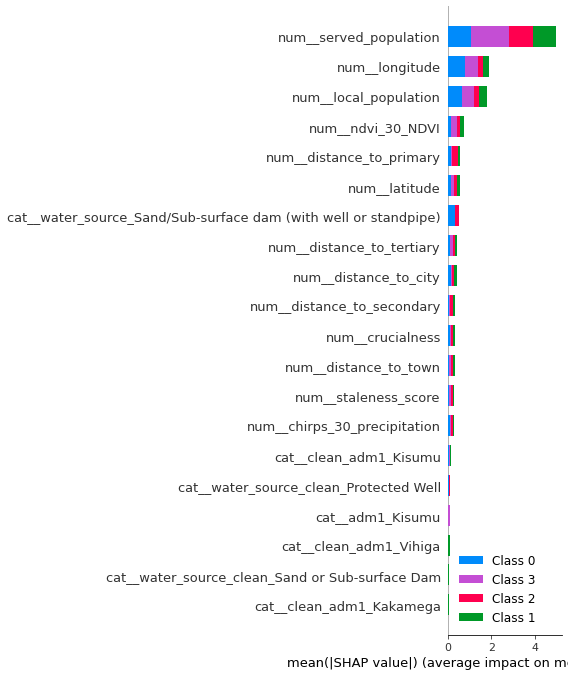

In [147]:
import shap

# SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Transform training data through the pipeline
X_transformed = best_xgb_model.named_steps['preprocessor'].transform(X_train)

# SHAP values
shap_values = explainer.shap_values(X_transformed)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)


- Model performance relies heavily on population and geographic attributes.

### Risk Classification Map (Geospatial Visualization)
- Using Plotly

In [149]:
import plotly.express as px

fig = px.scatter_mapbox(
    df_model,
    lat="latitude",
    lon="longitude",
    color="predicted_risk",
    size_max=10,
    zoom=6,
    mapbox_style="carto-positron",
    color_continuous_scale="RdYlGn_r",
    hover_data=['clean_adm1', 'clean_adm2', 'water_source_clean'],
)

fig.update_layout(title="Kenya Water Points Risk Map", margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/


`Conclusion`

This is a high-performing, interpretable, and spatially aware contamination risk classification model. The SHAP plots help build trust, while the map confirms meaningful predictions. This model is ready for deployment or communication with stakeholders, particularly for targeting interventions.